#Paquetes necesarios

In [41]:
import cv2
import pytesseract
import re
import matplotlib.pyplot as plt
import os
import numpy as np
import imutils

Primeras pruebas 

In [136]:
#Con yolo obtenemos qué elementos hay en las imágenes. La salida de la ejecución de la detección se almacena en el fichero salida.txt
!cd yolov7 && python detect.py --weights yolov7.pt --conf 0.25 --img-size 640 --source ..\images\ --view-img --device 0 > ../salida.txt

YOLOR  2022-11-10 torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6143.5MB)

Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
c:\Users\mnaranjo\Anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


La matrícula del coche im1.jpg es: 

La matrícula del coche im2.jpg es: 2488 KSX


La matrícula del coche im3.jpg es: E5074 Kp


La matrícula del coche im4.jpg es: =~.) \\D


La matrícula del coche im5.jpg es: £7637 KCB


La matrícula del coche im6.jpg es: ma it. \Y NI
V2b5 SKY)




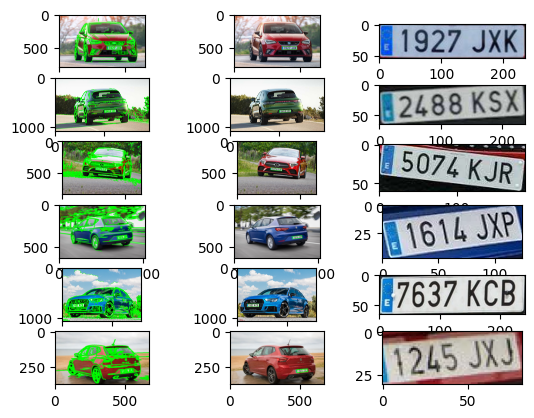

In [155]:
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

find = []
#Comprobamos que la salida de yolo nos diga que es un coche.
with open('salida.txt') as f:
    for line in f:
        
        if(line.rfind("car") != -1): #Si se encuentra la palabra car  
            nextLine = next(f)  
            #Obtenemos qué imagen tiene el coche
            find.append(re.search("im\d+.jpg",(nextLine.strip())))
        
#Número de imágenes con coches
numImages = len(find)

count = 1
for i in find:
    if(i):
        img = cv2.imread('./images/' + i.group()) 
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image = cv2.bilateralFilter(gray_image, 11, 17, 20)
        #Buscamos bordes con Canny
        edged = cv2.Canny(gray_image, 30, 200) 
        
        cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        img1=img_rgb.copy()
        #cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:30] # Ordenamos de mayor a menor para ir quitando los valores más pequeños
        cv2.drawContours(img1,cnts,-1,(0,255,0),3)
        plt.subplot(numImages,3,count)
        plt.imshow(img1)
        
        count += 1
        
        
        # loop over contours
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.018 * peri, True)
            x,y,w,h = cv2.boundingRect(c) #finds co-ordinates of the plate
            if len(approx) == 4 and cv2.contourArea(c) > 100 and w > h and w/h < 4.4  and w/h > 2: #chooses contours with 4 corners #
                    screenCnt = approx
                    new_img=img_rgb[y:y+h,x:x+w]
                    cv2.imwrite('./'+str(find.index(i) + 1)+'.png',new_img) #stores the new image
                    break   
            
        
                       
        cv2.drawContours(img_rgb, [screenCnt], -1, (0, 255, 0), 3)
        
        plt.subplot(numImages,3,count)
        plt.imshow(img_rgb)
        
        count += 1
        
        Cropped_loc=str(find.index(i) + 1) + '.png' #the filename of cropped image
        plt.subplot(numImages,3,count)
        plt.imshow(cv2.imread(Cropped_loc)) 
        
        count += 1
        
        
        #Aplica reconocedor a imagen cargada
        matricula = pytesseract.image_to_string(Cropped_loc, lang='eng')
        print("La matrícula del coche im" + str(find.index(i) + 1) + ".jpg es: " + matricula + "\n")